In [1]:
import copy, numpy as np
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import scipy.stats

#%%


In [2]:
#generate data 
def data_generation(sigma_x, thresh, size):
    z=np.random.normal(0, 1, size+1)
    x=np.random.normal(0, sigma_x, size)     
    zp=np.random.normal(0, np.sqrt(1-sigma_x*sigma_x), size+1)
    y=np.zeros(size+1)
    
    for i in range(size):
        if y[i]<thresh:
            y[i+1]=z[i+1]
        else:
            y[i+1]=x[i]+zp[i+1]  
            
    y_ts=y[0:size]
    y_ts=y_ts.reshape(-1,1)
  
    y_t=y[1:size+1]
    y_t=y_t.reshape(-1,1)
    x=x.reshape(-1,1)
    
    data = np.concatenate((x,y_t,y_ts),axis=1)
    return data


In [3]:

#%%
# Process arrival time sequences for TE calculation
def process_arrival_sequences(seq1, seq2, lag=1, embedding_dim=3):
    """
    Process two arrival time sequences for Transfer Entropy calculation.
    
    Args:
        seq1, seq2: arrival time sequences (1D arrays)
        lag: time lag for TE calculation
        embedding_dim: embedding dimension for state reconstruction
    
    Returns:
        data: processed data matrix [X_past, Y_future, Y_past] for TE(X->Y)
    """
    # Convert to numpy arrays
    seq1 = np.array(seq1).flatten()
    seq2 = np.array(seq2).flatten()
    
    # Normalize sequences (optional - helps with neural network training)
    seq1_norm = (seq1 - np.mean(seq1)) / (np.std(seq1) + 1e-8)
    seq2_norm = (seq2 - np.mean(seq2)) / (np.std(seq2) + 1e-8)
    
    # Create embedded vectors
    min_len = min(len(seq1_norm), len(seq2_norm))
    data_points = min_len - embedding_dim - lag + 1
    
    if data_points <= 0:
        raise ValueError(f"Sequences too short for embedding_dim={embedding_dim} and lag={lag}")
    
    # For TE(X->Y): need X_past, Y_future, Y_past
    X_past = np.zeros((data_points, embedding_dim))
    Y_future = np.zeros((data_points, 1))
    Y_past = np.zeros((data_points, embedding_dim))
    
    for i in range(data_points):
        # X past states (embedding_dim points)
        X_past[i, :] = seq1_norm[i:i+embedding_dim]
        # Y future state (lag steps ahead)
        Y_future[i, 0] = seq2_norm[i+embedding_dim+lag-1]
        # Y past states (embedding_dim points)
        Y_past[i, :] = seq2_norm[i:i+embedding_dim]
    
    # Combine for neural network input: [X_past, Y_future, Y_past]
    data = np.concatenate([X_past, Y_future, Y_past], axis=1)
    return data

#%%


In [4]:
# Calculate TE between two arrival time sequences
def calculate_te_sequences(seq1, seq2, lag=1, embedding_dim=3, 
                          train_ratio=0.75, iterations=500, tau=0.9):
    """
    Calculate Transfer Entropy from seq1 to seq2.
    
    Args:
        seq1, seq2: arrival time sequences
        lag: time lag for TE calculation
        embedding_dim: embedding dimension
        train_ratio: fraction of data for training
        iterations: training iterations
        tau: regularization parameter
    
    Returns:
        te_value: Transfer Entropy estimate
    """
    
    # Process sequences into training data
    data = process_arrival_sequences(seq1, seq2, lag, embedding_dim)
    size = len(data)
    train_size = int(size * train_ratio)
    
    # For TE calculation: I(Y_future; X_past | Y_past)
    # = I(Y_future; X_past, Y_past) - I(Y_future; Y_past)
    
    # Model P: I(Y_future; X_past, Y_past) - uses all features
    input_size_p = embedding_dim * 2 + 1  # X_past + Y_past + Y_future
    modelP = Class_Net(input_size=input_size_p, hidden_size=100, std=0.08)
    optimizerP = torch.optim.Adam(modelP.parameters(), lr=1e-3)
    
    # Model Q: I(Y_future; Y_past) - uses only Y features  
    input_size_q = embedding_dim + 1  # Y_past + Y_future
    modelQ = Class_Net(input_size=input_size_q, hidden_size=80, std=0.08)
    optimizerQ = torch.optim.Adam(modelQ.parameters(), lr=1e-3)
    
    # Train models
    tau_tensor = torch.tensor(tau)
    
    # Extract features for each model
    data_p = data  # All features: [X_past, Y_future, Y_past]
    data_q = np.concatenate([data[:, embedding_dim:embedding_dim+1],  # Y_future
                            data[:, embedding_dim+1:]], axis=1)        # Y_past
    
    mi_p = mi(data_p, size, train_size, modelP, optimizerP, iterations, tau_tensor, input_size=input_size_p)[0]
    mi_q = mi(data_q, size, train_size, modelQ, optimizerQ, iterations, tau_tensor, input_size=input_size_q)[0]
    
    # TE = I(Y_future; X_past, Y_past) - I(Y_future; Y_past)
    te_value = (mi_p - mi_q) * 1.4427  # Convert to bits
    
    return te_value

#%%


In [5]:
#generate data bar{y} 
def data_gen_zbar(data, size_g, data_net):
    data_z = data[:,2].reshape(-1,1)  
    data_z_ten = torch.FloatTensor(data_z)
    data_zbar = data_net(data_z_ten)
    sample_dataxyzbar = np.concatenate((data[:,[0,1]],data_zbar.detach().numpy()),axis=1)
    Jacobian_weight = torch.zeros((data_net.fc1.weight.shape[0], size_g)) 
    for i in range(size_g):
        output = torch.zeros(size_g,1)
        output[i] = 1
         #   each column is dz_1/dw_1, \cdots, dz_1/dw_n
        Jacobian_weight[:,i:i+1] = torch.autograd.grad(data_zbar,data_net.fc1.weight,
                                                           grad_outputs = output, 
                                                           retain_graph = True)[0]
    
    return sample_dataxyzbar, Jacobian_weight

#%%


In [6]:
#reconstruct data to create training data set and evaluation data set 
def recons_data(rho_data, size, train_size):  

    total_size = size
    train_index = np.random.choice(range(total_size), size=train_size, replace=False)
    test_index =  np.delete(np.arange(total_size), train_index, 0)
    joint_train = rho_data[train_index][:]
    joint_test = rho_data[test_index][:]

    # Fix: pass the number of features, not the number of samples
    input_size = rho_data.shape[1]  # number of features
    marg_data, joint_index, marginal_index= sample_batch(rho_data, input_size, 
                                                         batch_size=size, 
                                                         sample_mode='marginal')
    
    marg_train = marg_data[train_index][:]
    marg_test = marg_data[test_index][:]
    
    train_data = np.vstack((joint_train,marg_train))
 
    joint_label = np.ones(train_size)
    marg_label = np.zeros(train_size)  
    label = np.vstack((joint_label,marg_label)).flatten()
    return train_data, joint_test, marg_test, label, train_index, marginal_index
#%%


In [7]:
def sample_batch(data, input_size, batch_size, sample_mode='joint'):
    joint_index=0
    marginal_index2=0
    if input_size==2:
        if sample_mode == 'joint':
            joint_index = np.random.choice(range(data.shape[0]), size=batch_size, replace=False)
            batch = np.concatenate((data[joint_index][:,0].reshape(-1,1),data[joint_index][:,-1].reshape(-1,1)),axis=1)
        else:
            marginal_index1 = np.random.choice(range(data.shape[0]), size=batch_size, replace=False)
            marginal_index2 = np.random.choice(range(data.shape[0]), size=batch_size, replace=False)
            batch = np.concatenate((data[marginal_index1][:,0].reshape(-1,1),data[marginal_index2][:,-1].reshape(-1,1)),axis=1)
    else:
        if sample_mode == 'joint':
            joint_index = np.random.choice(range(data.shape[0]), size=batch_size, replace=False)
            batch = data[joint_index]
        else:
            # For marginal sampling: shuffle all rows independently to break dependencies
            # This creates the "marginal" distribution by destroying correlations
            marginal_index1 = np.random.choice(range(data.shape[0]), size=batch_size, replace=False)
            marginal_index2 = np.random.choice(range(data.shape[0]), size=batch_size, replace=False)
            
            # For Transfer Entropy, we want to break the connection between Y_future and the rest
            # Data structure: [X_past, Y_future, Y_past]
            embedding_dim = (input_size - 1) // 2
            
            # Keep X_past and Y_past from one set of indices
            X_past_Y_past = data[marginal_index1][:, np.concatenate([
                np.arange(embedding_dim),  # X_past indices
                np.arange(embedding_dim+1, input_size)  # Y_past indices  
            ])]
            
            # Take Y_future from different indices to break dependence
            Y_future = data[marginal_index2][:, embedding_dim:embedding_dim+1]
            
            # Reconstruct in original order: [X_past, Y_future, Y_past]
            batch = np.concatenate([
                X_past_Y_past[:, :embedding_dim],  # X_past
                Y_future,  # Y_future (shuffled)
                X_past_Y_past[:, embedding_dim:]   # Y_past
            ], axis=1)
            
    return batch, joint_index, marginal_index2
#%%


In [8]:
# define varitional auto encoder 
class VAE(nn.Module):
    def __init__(self,VAE_input_size=1, VAE_hidden_size=200):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(VAE_input_size, VAE_hidden_size)
        self.fc21 = nn.Linear(VAE_hidden_size, 1)
        self.fc22 = nn.Linear(VAE_hidden_size, 1)

        nn.init.normal_(self.fc1.weight,std=0.2)
        self.fc1.weight.requires_grad = True
        nn.init.normal_(self.fc21.weight,std=0.2)
        nn.init.constant_(self.fc21.bias, 0)
        nn.init.normal_(self.fc22.weight,std=0.2)
        nn.init.constant_(self.fc22.bias, 0)
            
    def encode(self, x):
        h1 = F.elu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparametrize(self, mu, logvar):
        # std = exp(0.5*logvar) without in-place ops; sample eps with correct dtype/device
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, x):
        mu, logvar = self.encode(x)
        zbar = self.reparametrize(mu, logvar)
        return zbar 


#%%


In [9]:
#classifier   
class Class_Net(nn.Module):
    def __init__(self, input_size, hidden_size, std):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 1)

        nn.init.normal_(self.fc1.weight, std=std)
        nn.init.constant_(self.fc1.bias, 0)
        nn.init.normal_(self.fc2.weight, std=std)
        nn.init.constant_(self.fc2.bias, 0)
        nn.init.normal_(self.fc3.weight, std=std)
        nn.init.constant_(self.fc3.bias, 0)

    def forward(self,input):
        m = nn.Sigmoid()
        output = F.elu(self.fc1(input))
        output = F.elu(self.fc2(output))
        logit = self.fc3(output)
        prob = m(logit)
        return logit, prob
#%% 


In [10]:
# Original piecewise lognormal data generation from piecewise_lognormal.py
def simulate_processes(total_time, lambda_x, intensity_table, seed=None):
    """
    Original function from piecewise_lognormal.py
    Simulates a Poisson process (X) and a conditional stochastic process (Y)
    sequentially.

    X is simulated first as a standard Poisson process using an efficient
    vectorized method.
    Y's intensity then depends on the history of both X and Y, with the
    intensity remaining constant between Y events.

    Args:
        total_time (float): The total duration of the simulation in seconds.
        lambda_x (float): The constant intensity (events/sec) of the Poisson process X.
        intensity_table (dict): The conditional intensity parameters
        seed (int): Random seed for reproducibility

    Returns:
        tuple: A tuple containing (events_x, events_y, count_table, plot_data)
    """
    if seed is not None:
        np.random.seed(seed)

    # --- Step 1: Simulate Process X (Poisson) ---
    num_events_x_estimate = int(lambda_x * total_time * 2)  # Add a 100% buffer
    inter_arrival_times_x = np.random.exponential(1.0/lambda_x, num_events_x_estimate)
    
    # Calculate the event times as the cumulative sum of inter-arrival times
    event_times_x_raw = np.cumsum(inter_arrival_times_x)
    
    # Truncate the event times at the total simulation time
    events_x = event_times_x_raw[event_times_x_raw <= total_time].tolist()

    assert event_times_x_raw[-1] > total_time

    # --- Step 2: Simulate Process Y (Conditional) ---
    events_y = []
    current_time = 0
    
    # Track the last two event times for Y to calculate inter-event times.
    last_event_y = -np.inf
    second_last_event_y = -np.inf  # No second last event at the start
    
    # Use an index to efficiently track the position in the events_x list
    x_event_index = 0

    count_table = {
        (False, False): 0,
        (False, True): 0,
        (True, False): 0,
        (True, True): 0
    }

    plot_data = {
        (False, False): [],
        (False, True): [],
        (True, False): [],
        (True, True): []
    }

    while current_time < total_time:
        # Advance the index to find the most recent X event(s) that occurred
        # before or at the current time. This is much more efficient than searching the list.
        while x_event_index < len(events_x) and events_x[x_event_index] <= current_time:
            x_event_index += 1
            
        # Get the last two event times for X using the index
        last_event_x = events_x[x_event_index - 1] if x_event_index > 0 else -np.inf
        second_last_event_x = events_x[x_event_index - 2] if x_event_index > 1 else -np.inf
        
        # Calculate inter-event times
        inter_event_x = last_event_x - second_last_event_x if second_last_event_x > -np.inf else np.inf
        inter_event_y = last_event_y - second_last_event_y if second_last_event_y > -np.inf else np.inf

        # Determine the correct parameters from the table
        y_small = inter_event_y <= 0.01  # 10ms threshold
        x_small = inter_event_x <= 0.01
        
        mu, sigma = intensity_table[(y_small, x_small)]
        count_table[(y_small, x_small)] += 1  # Count how many times we are in this state

        # Simulate the time to the next Y event using lognormal distribution
        time_to_next_y = np.random.lognormal(mean=mu, sigma=sigma)
        next_event_y_time = last_event_y + time_to_next_y if last_event_y > 0 else time_to_next_y
        
        # Store data for plotting
        plot_data[(y_small, x_small)].append(time_to_next_y)

        if next_event_y_time <= total_time:
            events_y.append(next_event_y_time)
            # Update the last two Y event times
            second_last_event_y = last_event_y
            last_event_y = next_event_y_time
            # Advance time to the new Y event
            current_time = next_event_y_time
        else:
            # The next event is past the simulation time, so we stop.
            break
    
    return events_x, events_y, count_table, plot_data

def generate_piecewise_lognormal_sequences(n_events=1000, coupling_strength=0.3, total_time=None, seed=None):
    """
    Generate two coupled arrival time sequences using the original piecewise lognormal model.
    
    Args:
        n_events: target number of events (used to estimate simulation time if total_time not provided)
        coupling_strength: controls the strength of coupling between processes (0.0 to 1.0)
        total_time: if provided, overrides n_events for simulation duration
        seed: random seed for reproducibility
    
    Returns:
        seq1, seq2: arrival time sequences (X and Y processes)
    """
    if seed is not None:
        np.random.seed(seed)
    
    # Use original simulation parameters from piecewise_lognormal.py
    LAMBDA_X = 30  # events/sec for Poisson process X
    
    # Estimate simulation time if not provided
    if total_time is None:
        # Based on original results, Y process rate is typically 60-100 events/sec
        estimated_y_rate = 80  # rough estimate based on original results
        total_time = n_events / estimated_y_rate
    
    # Use the original intensity table from piecewise_lognormal.py with coupling modulation
    base_intensity_table = {
        (False, False): (-5, 0.5),   # Y_t > 10ms, X_t > 10ms, 
        (False, True): (-7, 2),      # Y_t > 10ms, X_t <= 10ms
        (True, False): (-3, 0.5),    # Y_t <= 10ms, X_t > 10ms
        (True, True): (-4, 1.5)      # Y_t <= 10ms, X_t <= 10ms
    }
    
    # Apply coupling strength to modulate the original parameters
    intensity_table = {}
    for (y_small, x_small), (base_mu, base_sigma) in base_intensity_table.items():
        if coupling_strength == 0.0:
            # No coupling: make all X states similar
            if y_small:
                intensity_table[(y_small, x_small)] = (-3.5, 1.0)  # Average for Y_small
            else:
                intensity_table[(y_small, x_small)] = (-6, 1.25)   # Average for Y_large
        else:
            # Scale the original differences by coupling_strength
            # Find the corresponding base case when X_small=False
            base_case_mu, base_case_sigma = base_intensity_table[(y_small, False)]
            
            if x_small:
                # Apply coupling effect when X has small inter-event times
                mu_diff = base_mu - base_case_mu
                sigma_diff = base_sigma - base_case_sigma
                
                new_mu = base_case_mu + coupling_strength * mu_diff
                new_sigma = base_case_sigma + coupling_strength * sigma_diff
                
                intensity_table[(y_small, x_small)] = (new_mu, new_sigma)
            else:
                # Use base parameters when X has large inter-event times
                intensity_table[(y_small, x_small)] = (base_mu, base_sigma)
    
    # Generate the coupled processes using original simulation function
    events_x, events_y, count_table, plot_data = simulate_processes(
        total_time, LAMBDA_X, intensity_table, seed
    )
    
    # Convert to numpy arrays 
    seq1 = np.array(events_x)  # X process
    seq2 = np.array(events_y)  # Y process
    
    return seq1, seq2

# Training functions
def train(rho_data, size, train_size, mine_net, optimizer, iteration, input_size, tau):
    criterion = nn.BCEWithLogitsLoss()
    diff_et = torch.tensor(0.0)
    grads = None
    grads_placeholder = None
    last_index1 = None
    data, test_p0, test_q0, label, train_index, marg_index = recons_data(rho_data, size, 
                                                                           train_size)
    default_batch_size = max(1, int(len(data) / 4))
    
    # Fix: use the actual feature dimension from the data
    data_input_size = data.shape[1]
    
    for i in range(iteration):   
        batch_size = int(len(data)/4)
        if input_size == 2:  
            test_p = torch.FloatTensor(test_p0[:,[0,-1]])  # first and last columns
            test_q = torch.FloatTensor(test_q0[:,[0,-1]])
        else: 
            test_p = torch.FloatTensor(test_p0)
            test_q = torch.FloatTensor(test_q0)
        
        train_batch, index1, index2 = sample_batch(data, data_input_size, 
                                                   batch_size = batch_size, 
                                                   sample_mode = 'joint')
        label_batch = label[index1]
        train_batch = torch.autograd.Variable(torch.FloatTensor(train_batch), requires_grad=True)
        if grads_placeholder is None:
            grads_placeholder = torch.zeros_like(train_batch)
        label_batch = torch.FloatTensor(label_batch)
        last_index1 = index1
        
        logit = mine_net(train_batch)[0]
        loss = criterion(logit.reshape(-1), label_batch)
        
        # Always backprop before stepping; on last iter, capture input gradients
        optimizer.zero_grad()
        loss.backward()
        if i == iteration - 1:
            if train_batch.grad is not None:
                grads = train_batch.grad.detach().clone()
            else:
                grads = grads_placeholder.detach().clone()
        optimizer.step()
        
        if i >= iteration - 101:
            with torch.no_grad():
                prob_p = mine_net(test_p)[1]
                rn_est_p = prob_p / (1 - prob_p + 1e-8)  # Add small epsilon to avoid division by zero
                finp_p = torch.log(torch.abs(rn_est_p) + 1e-8)

                prob_q = mine_net(test_q)[1]
                rn_est_q = prob_q / (1 - prob_q + 1e-8)  # Add small epsilon
                a = torch.abs(rn_est_q)
                clip = torch.max(torch.min(a, torch.exp(tau)), torch.exp(-tau))
                diff_et = diff_et + torch.max(
                    torch.mean(finp_p) - torch.log(torch.mean(clip)),
                    torch.tensor(0.0),
                )
            
    safe_grads = grads if grads is not None else grads_placeholder
    safe_index = last_index1 if last_index1 is not None else np.arange(default_batch_size)
    return (diff_et/100).detach().cpu().numpy(), safe_grads, safe_index, train_index, marg_index

def mi(rho_data, size, train_size, model, optimizer, repo, tau, input_size):    
    mi, grad, index, train_index, marg_index = train(rho_data, size, train_size,
                                                     model, optimizer, repo, 
                                                     input_size, tau=tau)
    
    return mi, grad, index, train_index, marg_index

def ma(a, window_size=20):
    return [np.mean(a[i:i+window_size]) for i in range(0,len(a)-window_size)]

Transfer Entropy Calculation for Piecewise Lognormal Arrival Time Sequences

Testing coupling strength: 0.00
  Realization 1: TE(1->2)=0.3681, TE(2->1)=0.0065
  Realization 1: TE(1->2)=0.3681, TE(2->1)=0.0065
  Realization 2: TE(1->2)=0.1861, TE(2->1)=-0.0132
  Realization 2: TE(1->2)=0.1861, TE(2->1)=-0.0132
  Realization 3: TE(1->2)=0.3014, TE(2->1)=0.2135
  Realization 3: TE(1->2)=0.3014, TE(2->1)=0.2135
  Realization 4: TE(1->2)=0.0272, TE(2->1)=0.1262
  Realization 4: TE(1->2)=0.0272, TE(2->1)=0.1262
  Realization 5: TE(1->2)=0.0982, TE(2->1)=0.3648

Testing coupling strength: 0.11
  Realization 5: TE(1->2)=0.0982, TE(2->1)=0.3648

Testing coupling strength: 0.11
  Realization 1: TE(1->2)=0.4077, TE(2->1)=0.1311
  Realization 1: TE(1->2)=0.4077, TE(2->1)=0.1311
  Realization 2: TE(1->2)=-0.1789, TE(2->1)=0.0348
  Realization 2: TE(1->2)=-0.1789, TE(2->1)=0.0348
  Realization 3: TE(1->2)=0.4802, TE(2->1)=0.1235
  Realization 3: TE(1->2)=0.4802, TE(2->1)=0.1235
  Realization 4: TE(1

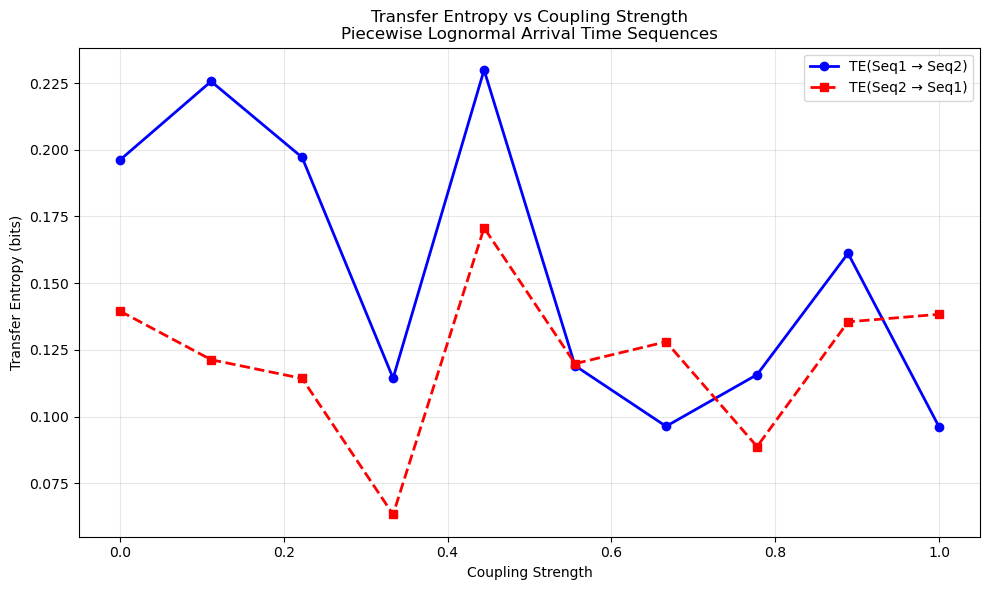


SUMMARY
Coupling Strengths: [0.         0.11111111 0.22222222 0.33333333 0.44444444 0.55555556
 0.66666667 0.77777778 0.88888889 1.        ]
TE(1->2): [np.float32(0.1962106), np.float32(0.22560982), np.float32(0.19715127), np.float32(0.11441406), np.float32(0.2298905), np.float32(0.119099975), np.float32(0.09640239), np.float32(0.11576338), np.float32(0.16119632), np.float32(0.09620089)]
TE(2->1): [np.float32(0.13955367), np.float32(0.121357575), np.float32(0.11433377), np.float32(0.06337184), np.float32(0.17073658), np.float32(0.119873844), np.float32(0.1280628), np.float32(0.088814765), np.float32(0.13554081), np.float32(0.13835901)]
Max TE(1->2): 0.2299
Max TE(2->1): 0.1707


In [11]:

def main():
    print("Transfer Entropy Calculation for Piecewise Lognormal Arrival Time Sequences")
    print("=" * 70)
    
    # Set random seed for reproducibility
    seed = 51
    np.random.seed(seed)
    
    # FAST_DEBUG mode to speed up debug runs
    if os.environ.get("FAST_DEBUG", "0") == "1":
        print("FAST_DEBUG mode enabled: using small datasets for quick testing.")
        n_events = 200
        iterations = 50
        n_realizations = 2
        coupling_strengths = [0.0, 0.2, 0.5]
    else:
        n_events = 10000
        iterations = 300
        n_realizations = 5
        coupling_strengths = np.linspace(0.0, 1.1, 10)
    
    # Test different coupling strengths
    te_results = []
    te_reverse = []  # TE in reverse direction
    
    for coupling in coupling_strengths:
        print(f"\nTesting coupling strength: {coupling:.2f}")
        
        te_values = []
        te_rev_values = []
        
        for realization in range(n_realizations):
            # Generate coupled sequences using piecewise lognormal model
            seq1, seq2 = generate_piecewise_lognormal_sequences(
                n_events=n_events, 
                coupling_strength=coupling,
                seed=seed + realization  # Different seed for each realization
            )
            
            try:
                # Calculate TE from seq1 to seq2
                te_forward = calculate_te_sequences(
                    seq1, seq2, 
                    lag=1, 
                    embedding_dim=3,
                    iterations=iterations,
                    tau=0.9
                )
                
                # Calculate TE from seq2 to seq1 (should be smaller)
                te_backward = calculate_te_sequences(
                    seq2, seq1, 
                    lag=1, 
                    embedding_dim=3,
                    iterations=iterations,
                    tau=0.9
                )
                
                te_values.append(te_forward)
                te_rev_values.append(te_backward)
                
                print(f"  Realization {realization+1}: TE(1->2)={te_forward:.4f}, TE(2->1)={te_backward:.4f}")
                
            except Exception as e:
                print(f"  Error in realization {realization+1}: {e}")
                te_values.append(0)
                te_rev_values.append(0)
        
        te_results.append(np.mean(te_values))
        te_reverse.append(np.mean(te_rev_values))
    
    # Plot results
    plt.figure(figsize=(10, 6))
    plt.plot(coupling_strengths, te_results, 'o-', color='blue', 
             label='TE(Seq1 → Seq2)', linewidth=2, markersize=6)
    plt.plot(coupling_strengths, te_reverse, 's--', color='red', 
             label='TE(Seq2 → Seq1)', linewidth=2, markersize=6)
    
    plt.xlabel('Coupling Strength')
    plt.ylabel('Transfer Entropy (bits)')
    plt.title('Transfer Entropy vs Coupling Strength\nPiecewise Lognormal Arrival Time Sequences')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    # Save results
    plt.savefig("te_piecewise_lognormal_sequences.pdf", dpi=300, bbox_inches='tight')
    plt.savefig("te_piecewise_lognormal_sequences.png", dpi=300, bbox_inches='tight')
    
    plt.show()
    
    # Print summary
    print("\n" + "="*60)
    print("SUMMARY")
    print("="*60)
    print(f"Coupling Strengths: {coupling_strengths}")
    print(f"TE(1->2): {te_results}")
    print(f"TE(2->1): {te_reverse}")
    print(f"Max TE(1->2): {max(te_results):.4f}")
    print(f"Max TE(2->1): {max(te_reverse):.4f}")

def example_usage():
    """
    Example of how to use the TE calculation with piecewise lognormal data.
    """
    print("Example: Piecewise Lognormal Arrival Time Sequences")
    print("-" * 50)
    
    # Generate example data using piecewise lognormal model
    print("Generating example data using piecewise lognormal model...")
    arrival_times_1, arrival_times_2 = generate_piecewise_lognormal_sequences(
        n_events=50,           # Small dataset for demo
        coupling_strength=0.4,  # Moderate coupling
        seed=123
    )
    
    print(f"Process X (seq1): {len(arrival_times_1)} events")
    print(f"Process Y (seq2): {len(arrival_times_2)} events")
    print(f"X events (first 10): {arrival_times_1[:10]}")
    print(f"Y events (first 10): {arrival_times_2[:10]}")
    
    try:
        # Calculate TE from sequence 1 to sequence 2 (X -> Y)
        te_1_to_2 = calculate_te_sequences(
            arrival_times_1, arrival_times_2,
            lag=1,           # time lag
            embedding_dim=2, # reduced for short sequences
            iterations=100   # fewer iterations for demo
        )
        
        # Calculate TE from sequence 2 to sequence 1 (Y -> X)
        te_2_to_1 = calculate_te_sequences(
            arrival_times_2, arrival_times_1,
            lag=1,
            embedding_dim=2,
            iterations=100
        )
        
        print(f"\nTransfer Entropy Results:")
        print(f"TE(X → Y): {te_1_to_2:.4f} bits")
        print(f"TE(Y → X): {te_2_to_1:.4f} bits")
        
        if te_1_to_2 > te_2_to_1:
            print("Process X appears to drive Process Y (expected for this model)")
        elif te_2_to_1 > te_1_to_2:
            print("Process Y appears to drive Process X")
        else:
            print("No clear directional coupling detected")
            
        print(f"\nCoupling strength used: 0.4")
        print(f"Expected: X should drive Y in the piecewise lognormal model")
            
    except Exception as e:
        print(f"Error: {e}")
        print("Note: Sequences may be too short for the chosen embedding dimension")



In [ ]:

if __name__ == "__main__":
    # Choose what to run:
    run_mode = os.environ.get("RUN_MODE", "main")  # options: "main", "example"
    
    if run_mode == "example":
        example_usage()
    else:
        main()
    


=== RUNNING FULL ANALYSIS WITH PIECEWISE LOGNORMAL DATA ===
Transfer Entropy Calculation for Piecewise Lognormal Arrival Time Sequences
FAST_DEBUG mode enabled: using small datasets for quick testing.

Testing coupling strength: 0.00
  Realization 1: TE(1->2)=-0.0002, TE(2->1)=0.0141
  Realization 1: TE(1->2)=-0.0002, TE(2->1)=0.0141
  Realization 2: TE(1->2)=0.0000, TE(2->1)=-0.0002

Testing coupling strength: 0.20
  Realization 2: TE(1->2)=0.0000, TE(2->1)=-0.0002

Testing coupling strength: 0.20
  Realization 1: TE(1->2)=0.0025, TE(2->1)=-0.0028
  Realization 1: TE(1->2)=0.0025, TE(2->1)=-0.0028
  Realization 2: TE(1->2)=-0.0004, TE(2->1)=0.0000

Testing coupling strength: 0.50
  Realization 2: TE(1->2)=-0.0004, TE(2->1)=0.0000

Testing coupling strength: 0.50
  Realization 1: TE(1->2)=-0.0054, TE(2->1)=-0.0029
  Realization 1: TE(1->2)=-0.0054, TE(2->1)=-0.0029
  Realization 2: TE(1->2)=0.0004, TE(2->1)=0.0000
  Realization 2: TE(1->2)=0.0004, TE(2->1)=0.0000


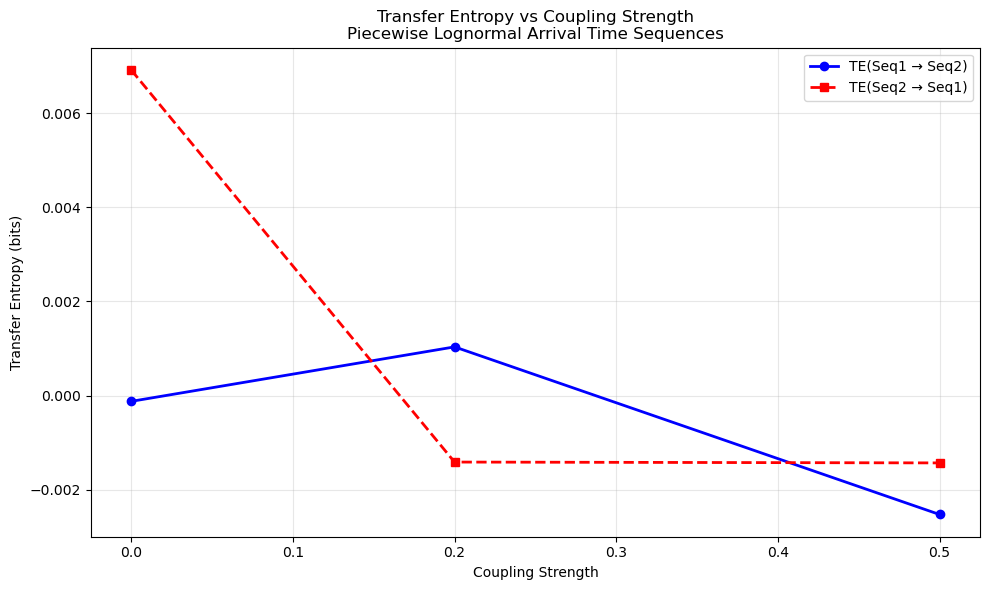


SUMMARY
Coupling Strengths: [0.0, 0.2, 0.5]
TE(1->2): [np.float32(-0.00012413041), np.float32(0.00103368), np.float32(-0.00252851)]
TE(2->1): [np.float32(0.006919012), np.float32(-0.001414131), np.float32(-0.0014320981)]
Max TE(1->2): 0.0010
Max TE(2->1): 0.0069


In [12]:
# Run the full analysis with piecewise lognormal data
print("=== RUNNING FULL ANALYSIS WITH PIECEWISE LOGNORMAL DATA ===")
os.environ["FAST_DEBUG"] = "1"  # Use fast debug mode

# Run the updated main analysis
main()